# Crystal Structure Classification

In [1]:
%%time

import MDAnalysis as mda
import numpy as np
from ordpy import *
import plotly.graph_objects as go
import ipywidgets as widgets

hcp_trajectories = ("hcp", mda.Universe('hcp_80_atoms_trajectory.lammpsdump', in_memory=True))
hcp_snapshots = ("hcp", mda.Universe('hcp_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

diamond_trajectories = ("diamond", mda.Universe('diamond_80_atoms_trajectory.lammpsdump', in_memory=True))
diamond_snapshots = ("diamond", mda.Universe('diamond_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

a5_trajectories = ("a5", mda.Universe('a5_80_atoms_trajectory.lammpsdump', in_memory=True))
a5_snapshots = ("a5", mda.Universe('a5_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

bct5_trajectories = ("bct5", mda.Universe('bct5_80_atoms_trajectory.lammpsdump', in_memory=True))
bct5_snapshots = ("bct5", mda.Universe('bct5_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

bc8_trajectories = ("bc8", mda.Universe('bc8_50_atoms_trajectory.lammpsdump', in_memory=True))
bc8_snapshots = ("bc8", mda.Universe('bc8_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

liq_trajectories = ("liquid", mda.Universe('liq_80_atoms_trajectory.lammpsdump', in_memory=True))
liq_snapshots = ("liquid", mda.Universe('liquid_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

amorph_trajectories = ("amorph", mda.Universe('amorph_50_atoms_trajectory.lammpsdump', in_memory=True))
amorph_snapshots = ("amorph", mda.Universe('amorph_last_50_snapshots_of_all_atoms.lammpsdump', in_memory=True))

/opt/conda/lib/python3.9/site-packages/MDAnalysis/topology/LAMMPSParser.py:632: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/opt/conda/lib/python3.9/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


CPU times: user 55.8 s, sys: 5.67 s, total: 1min 1s
Wall time: 1min


## Ergodic properties demonstration

In [2]:
rng = np.random.default_rng()

def demonstrate_ergodic_property(trajectories, snapshots):

    figure = go.Figure()
    
    for cs_name, universe in trajectories:
        random_atom = rng.choice(len(universe.atoms))
        velocities = [np.linalg.norm(ts.velocities[random_atom].tolist()) for ts in universe.trajectory[-5000:]]
        hist, bin_edges = np.histogram(velocities, bins=100, density=True)
        figure.add_trace(go.Scatter(x=[e for e in bin_edges], y=hist, mode='markers', name=f'atom {random_atom} from {cs_name}'))
        
    for cs_name, universe in snapshots:
        random_snapshot = rng.choice(len(universe.trajectory))
        ts = universe.trajectory[random_snapshot]
        velocities = [np.linalg.norm(a.velocity.tolist()) for a in universe.atoms]
        hist, bin_edges = np.histogram(velocities, bins=100, density=True)
        figure.add_trace(go.Scatter(x=[e for e in bin_edges], y=hist, mode='markers', name=f'snapshot {random_snapshot} from {cs_name}'))
            
    figure.show()

In [3]:
widgets.interact(demonstrate_ergodic_property, 
                 trajectories = widgets.SelectMultiple(
                     options={'Random bct5 atoms\' trajectories': bct5_trajectories,
                              'Random bc8 atoms\' trajectories': bc8_trajectories,
                              'Random a5 atoms\' trajectories': a5_trajectories,
                              'Random hcp atoms\' trajectories': hcp_trajectories,
                              'Random diamond atoms\' trajectories': diamond_trajectories,
                              'Random liquid atoms\' trajectories': liq_trajectories,
                              'Random amorph atoms\' trajectories': amorph_trajectories,
                              }),
                 snapshots = widgets.SelectMultiple(
                     options={'Random bct5 system\'s snapshot': bct5_snapshots,
                              'Random bc8 system\'s snapshot': bc8_snapshots,
                              'Random hcp system\'s snapshot': hcp_snapshots,
                              'Random a5 system\'s snapshot': a5_snapshots,
                              'Random liquid system\'s snapshot': liq_snapshots,
                              'Random amorph system\'s snapshot': amorph_snapshots,
                              'Random diamond system\'s snapshot': diamond_snapshots
                              })
                );

interactive(children=(SelectMultiple(description='trajectories', options={"Random bct5 atoms' trajectories": (…

## Different processes generate same distribution

The distribution of the velocities of the liquid phase is different from the other distributions because liquid phase exists in higher temperatures. The other distrubutions were generated at 300 K and look the same, according to expectations. We don't think it is possible to classify different phases from the same velocity distribution. However, the same distribution can be generated by different processes (eg. the sequence of consecutive speeds of an atom), as demonstrated below.

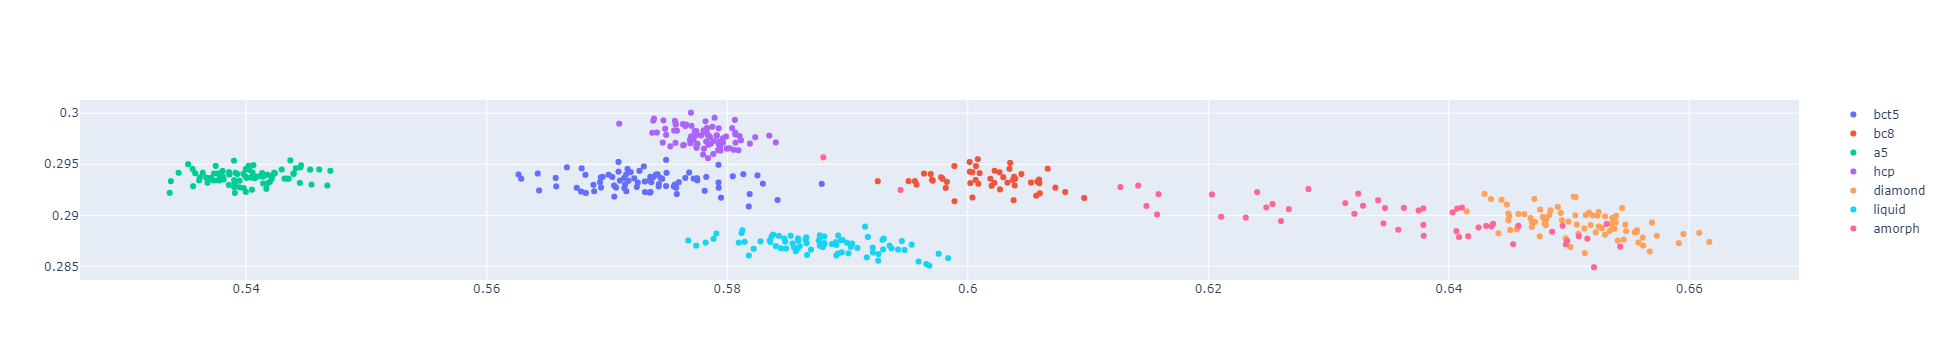

CPU times: user 1min 20s, sys: 199 ms, total: 1min 20s
Wall time: 1min 20s


In [4]:
%%time

ce_plane = go.Figure()

for cs_name, universe in [bct5_trajectories,
                          bc8_trajectories, 
                          a5_trajectories, 
                          hcp_trajectories, 
                          diamond_trajectories, 
                          liq_trajectories,
                          amorph_trajectories
                         ]:
    
    ce = [complexity_entropy(v, dx=4) for v in [[np.linalg.norm(ts.velocities[a].tolist()) for ts in universe.trajectory[-8000:]] for a in range(len(universe.atoms))]]
    ce_plane.add_trace(go.Scatter(x=[c for c, _ in ce], y=[e for _, e in ce], mode='markers', name=f'{cs_name}'))
    
ce_plane.show()

## An atom's walk through complexity plane

This approach makes an opportunity to analyse phase transitions as show below.

In [5]:
liquid_to_amorph_cooling_traj = mda.Universe('walk_17_atoms_trajectory.lammpsdump', in_memory=True)

/opt/conda/lib/python3.9/site-packages/MDAnalysis/topology/LAMMPSParser.py:632: UserWarning:

Guessed all Masses to 1.0

/opt/conda/lib/python3.9/site-packages/MDAnalysis/core/universe.py:658: UserWarning:

Reader has no dt information, set to 1.0 ps



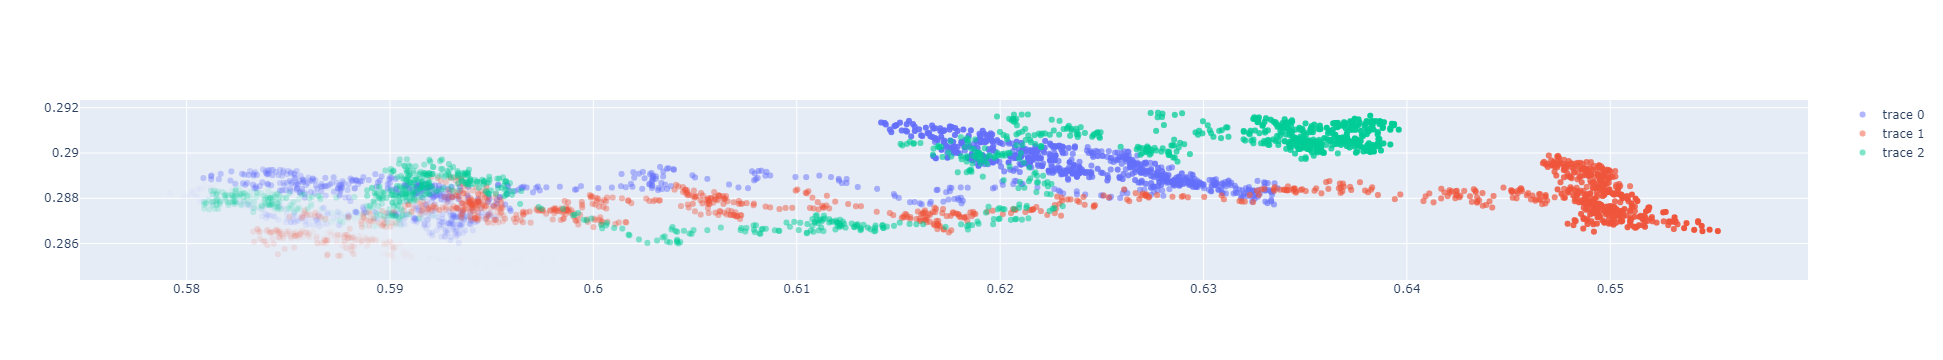

CPU times: user 10min 25s, sys: 257 ms, total: 10min 25s
Wall time: 10min 25s


In [8]:
%%time

#It usually takes me ~10 min. to execute this cell for a given data set (for 3 atoms' trajectories). 

observation_length = 8000

ce_walk = go.Figure()

for a in range(3):# range(len(liquid_to_amorph_cooling_traj.atoms)):
    walk_ce = []
    for i in range(observation_length, len(liquid_to_amorph_cooling_traj.trajectory), 50):
        velocities = [np.linalg.norm(ts.velocities[a].tolist()) for ts in liquid_to_amorph_cooling_traj.trajectory[i-observation_length:i]]
        walk_ce.append(complexity_entropy(velocities, dx=4)) if len(velocities) > 4 else None
        
    ce_walk.add_trace(go.Scatter(x=[c for c, _ in walk_ce], y=[e for _, e in walk_ce], mode='markers',
                                 marker=dict(opacity=[i for i in np.linspace(0,1,len(walk_ce))])))
        
ce_walk.show()